### Lectura y limpieza de datos 

In [5]:
import pandas as pd 
import os
import numpy as np 
import re
import unicodedata
import nltk
from nltk.corpus import stopwords

# Aseguramos que las stopwords estén disponibles
try:
    stopwords.words('spanish')
except LookupError:
    nltk.download('stopwords')

# Ruta de lectura
ruta = "../data"
archivo = os.path.join(ruta, "Rest-Mex_2025_train.csv") 

with open(archivo, 'r', encoding='utf-8', errors='replace') as f:
    Data = pd.read_csv(f)

# Arreglamos problemas de codificación
def arregla_mojibake(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except:
        return texto

Data['Title'] = Data['Title'].fillna('').apply(arregla_mojibake)
Data['Review'] = Data['Review'].fillna('').apply(arregla_mojibake)

# Creamos columna base con texto leído y concatenado
Data['Texto_Leido'] = (Data['Title'] + ' ' + Data['Review']).str.strip()

# Función de limpieza profunda para modelos clásicos
stopwords_es = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    texto = texto.lower()
    # Quitamos acentos
    texto = unicodedata.normalize('NFD', texto)
    texto = ''.join([char for char in texto if unicodedata.category(char) != 'Mn'])
    # Eliminamos caracteres no alfabéticos
    texto = re.sub(r'[^a-zñü\s]', '', texto)
    palabras = texto.split()
    palabras = [p for p in palabras if p not in stopwords_es]
    return ' '.join(palabras).strip()

# Generamos columna limpia
Data['Texto_Limpio'] = Data['Texto_Leido'].apply(limpiar_texto)

# Eliminamos columnas originales
Data = Data.drop(columns=['Title', 'Review'])

In [3]:
import torch
print(torch.cuda.is_available())  # True si está bien
print(torch.cuda.get_device_name(0))  # Nombre de tu GPU


True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


### Clasificacion con BETO

In [4]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# 1. Cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# 2. Asegurar que las etiquetas sean válidas (1 a 5) y convertirlas a 0-4
Data = Data[Data['Polarity'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
Data['label'] = Data['Polarity'].astype(int) - 1

# 3. Split de datos
train_texts, val_texts, train_labels, val_labels = train_test_split(
    Data['Texto_Leido'].tolist(),
    Data['label'].tolist(),
    test_size=0.2,
    stratify=Data['label']
)

# 4. Tokenización
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)



In [5]:

# 5. Dataset personalizado
class RMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RMDataset(train_encodings, train_labels)
val_dataset = RMDataset(val_encodings, val_labels)

# 6. Cálculo de pesos de clase (para el dataset desbalanceado)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# 7. Cargar modelo BERT con clasificación para 5 clases
model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=5
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# 8. Definir función de métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {"accuracy": acc, "f1": f1}

# 9. Usar Trainer personalizado para incluir class_weights
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


# 10. Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./resultados_beto",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

# 11. Entrenador
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# 12. ENTRENAMIENTO en GPU (si está disponible)
trainer.train()

c:\Users\uzgre\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.857200,1.037642,0.640456,0.664765
2,0.902600,1.019604,0.735527,0.742114
3,0.733000,1.102260,0.714931,0.729511


TrainOutput(global_step=31209, training_loss=0.8307517970352004, metrics={'train_runtime': 11579.6044, 'train_samples_per_second': 43.121, 'train_steps_per_second': 2.695, 'total_flos': 3.284503772378112e+16, 'train_loss': 0.8307517970352004, 'epoch': 3.0})

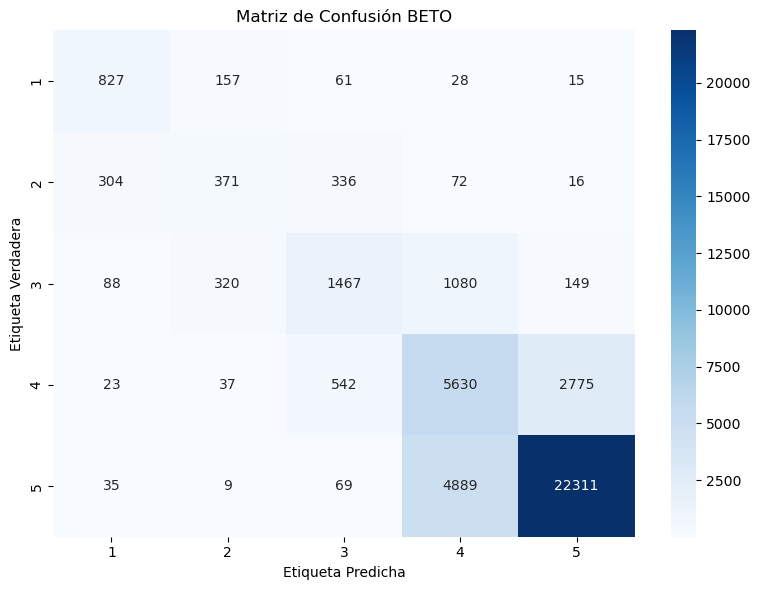

Reporte de Clasificación (F1, Precision, Recall por clase):
              precision    recall  f1-score   support

     Muy Neg      0.648     0.760     0.699      1088
         Neg      0.415     0.338     0.372      1099
      Neutro      0.593     0.473     0.526      3104
         Pos      0.481     0.625     0.544      9007
     Muy Pos      0.883     0.817     0.849     27313

    accuracy                          0.736     41611
   macro avg      0.604     0.602     0.598     41611
weighted avg      0.756     0.736     0.742     41611



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 13. PREDICCIONES sobre el conjunto de validación
preds_output = trainer.predict(val_dataset)
logits = preds_output.predictions
preds = np.argmax(logits, axis=1)

# 14. MATRIZ DE CONFUSIÓN
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión BETO")
plt.tight_layout()
plt.show()

# 15. REPORTE DETALLADO
print("Reporte de Clasificación (F1, Precision, Recall por clase):")
print(classification_report(val_labels, preds, digits=3, target_names=["Muy Neg", "Neg", "Neutro", "Pos", "Muy Pos"]))


### Cargamos modelos ya entrenados y hacemos predicciones

In [ ]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# Paso 1: Configurar ruta del mejor checkpoint
checkpoint_path = "./resultados_beto/checkpoint-20806" 

# Paso 2: Cargar tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Paso 3: Enviar modelo a dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
# Paso 4: Preprocesar nuevos textos
nuevos_textos = [
    "La comida fue excelente, definitivamente volveré.",
    "El servicio estuvo lento y desagradable.",
    "No tengo una opinión clara."
]

inputs = tokenizer(nuevos_textos, truncation=True, padding=True, max_length=128, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    predicciones = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Mostrar resultados
for texto, pred in zip(nuevos_textos, predicciones):
    print(f"Texto: {texto}\n→ Predicción de polaridad: {pred + 1}\n")



Texto: La comida fue excelente, definitivamente volveré.
→ Predicción de polaridad: 5

Texto: El servicio estuvo lento y desagradable.
→ Predicción de polaridad: 2

Texto: No tengo una opinión clara.
→ Predicción de polaridad: 2



In [8]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Seleccionar 3 textos al azar
muestras = Data[['Texto_Leido', 'Polarity']].sample(10, random_state=42).reset_index(drop=True)

# Cargar modelo y tokenizer
checkpoint_path = "./resultados_beto/checkpoint-20806"  # ← Ajusta con el número real
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Enviar a dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Tokenizar entradas
inputs = tokenizer(
    list(muestras['Texto_Leido']),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predecir
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Mostrar resultados
for i, row in muestras.iterrows():
    print(f"\nTexto {i+1}: {row['Texto_Leido']}")
    print(f"→ Polaridad real: {row['Polarity']}  |  Predicción modelo: {preds[i]+1}")



Texto 1: MEXICANO Es un lugar bellísimo, para llegar es necesario transportarte en lancha la cual tiene un precio bastante accesible, en la isla venden varias artesanías del lugar, desde prendas de vestir, antojitos mexicano, recuerditos y demás, su gente es muy amable, la mayoria de las personas conservan su lengua nativa, el lugar es pequeño pero fácil de caminar en una tarde, guarda muchas tradiciones mexicanas que se han perdido y te transporta a un lugar perdido en el tiempo
→ Polaridad real: 4.0  |  Predicción modelo: 5

Texto 2: Una vista sensacional El lugar es muy agradable, con una vista realmente increíble, la atención de los meseros muy buena, pero la comida no es nada fuera de lo común e incluso las porciones son pequeñas. La carta de vinos pequeña, pero razonablemente completa.
→ Polaridad real: 3.0  |  Predicción modelo: 3

Texto 3: Bastante recomendable para pasar la tarde Es una plaza en forma de herradura con muchos juegos infantiles para niños, grandes jardines con 